In [1]:
import pandas as pd

# Read the JSON file containing Slack users
users_df = pd.read_json('slack/users.json')

# Remove bots and restricted accounts from the DataFrame
users_df = users_df[~(users_df['is_bot'] | users_df['is_workflow_bot'] | users_df['is_restricted'])]

# Create dictionary with selected user information
users_dict = {
    row['id']: {
        'name': row['name'],
        'deleted': row['deleted'],
        'real_name': row['real_name'],
        'tz': row['tz'],
        'tz_label': row['tz_label'],
        'profile': row['profile'],
        'image_512': row['profile']['image_512'] if 'image_512' in row['profile'] else None
    }
    for _, row in users_df.iterrows()
}

# Display first item to verify the structure
list(users_dict.items())[0]

('U015GGN1SBU',
 {'name': 'jeroen',
  'deleted': False,
  'real_name': 'Jeroen Van Hautte',
  'tz': 'Europe/Brussels',
  'tz_label': 'Central European Time',
  'profile': {'title': '',
   'phone': '',
   'skype': '',
   'real_name': 'Jeroen Van Hautte',
   'real_name_normalized': 'Jeroen Van Hautte',
   'display_name': 'Jeroen',
   'display_name_normalized': 'Jeroen',
   'fields': {'Xf025DQTHFL6': {'value': 'https://calendar.google.com/calendar/selfsched?sstoken=UUtyVEFjRWozS3JyfGRlZmF1bHR8ODcxYjFmNTlkNDljNDQ1YTQxYjZkMDJjNDNkNjJkNDk',
     'alt': ''}},
   'status_text': '',
   'status_emoji': '',
   'status_emoji_display_info': [],
   'status_expiration': 0,
   'avatar_hash': 'e4b428b843e2',
   'image_original': 'https://avatars.slack-edge.com/2023-10-25/6091453713091_e4b428b843e2b8333bef_original.png',
   'is_custom_image': True,
   'email': 'jeroen@techwolf.ai',
   'huddle_state': 'default_unset',
   'huddle_state_expiration_ts': 0,
   'first_name': 'Jeroen',
   'last_name': 'Van Hau

In [2]:
len(users_dict)

196

In [3]:
import json
import os
from datetime import datetime
from collections import defaultdict

def get_thread_interactions(channel_name, users_dict, start_date=None, end_date=None):
    """
    Analyze thread interactions between users in a specific Slack channel within a date range.
    
    Args:
        channel_name (str): Name of the Slack channel to analyze
        users_dict (dict): Dictionary of valid Slack users to consider
        start_date (str, optional): Start date in YYYY-MM-DD format
        end_date (str, optional): End date in YYYY-MM-DD format
        
    Returns:
        dict: Dictionary with dates as keys and lists of user groups as values
    """
    channel_path = f"slack/{channel_name}"
    interactions_by_date = {}
    
    # Convert date strings to datetime objects if provided
    start_dt = datetime.strptime(start_date, '%Y-%m-%d') if start_date else None
    end_dt = datetime.strptime(end_date, '%Y-%m-%d') if end_date else None
    
    # Iterate through JSON files in the channel directory
    for filename in os.listdir(channel_path):
        if not filename.endswith('.json'):
            continue
            
        date = filename.replace('.json', '')
        
        # Skip if date is outside specified range
        try:
            file_dt = datetime.strptime(date, '%Y-%m-%d')
        except ValueError:
            continue
        if start_dt and file_dt < start_dt:
            continue
        if end_dt and file_dt > end_dt:
            continue
            
        file_path = os.path.join(channel_path, filename)
        
        # Read and parse JSON file
        with open(file_path, 'r') as f:
            messages = json.load(f)
            
        # Track threads and their participants
        thread_participants = defaultdict(set)
        
        # Process each message
        for msg in messages:
            if 'user' not in msg or msg['user'] not in users_dict:
                continue
                
            # Get thread ID (either thread_ts or ts for root message)
            thread_id = msg.get('thread_ts', msg.get('ts'))
            if not thread_id:
                continue
                
            # Add user to thread participants
            thread_participants[thread_id].add(msg['user'])
        
        # Convert thread participants to list of interactions
        interactions = [list(participants) for participants in thread_participants.values() if len(participants) > 0]

        #only retain the first 3 persons in the interaction
        interactions = [interaction[:3] for interaction in interactions]
        
        if interactions:
            interactions_by_date[date] = interactions
            
    return interactions_by_date

# interactions = get_thread_interactions('stay-wholesome', users_dict, 
#                                      start_date='2023-04-30', 
#                                      end_date='2024-04-30')
interactions = get_thread_interactions('stay-wholesome', users_dict)

# Print results
for date, thread_groups in interactions.items():
    print(f"\n{date}:")
    for group in thread_groups:
        # Convert user IDs to names for readability
        user_names = [users_dict[uid]['name'] for uid in group]
        print(f"  {user_names}")


2023-08-21:
  ['jeroen']

2023-02-21:
  ['marijn']
  ['amber']
  ['gilles']
  ['severine']
  ['jensjoris']
  ['niels']
  ['gilles']
  ['marijn', 'amber']
  ['amber', 'niels']
  ['andries']
  ['thibo']
  ['gilles']
  ['marijn']

2023-07-14:
  ['robbe', 'alya', 'niels']

2023-02-23:
  ['thomas']

2023-03-02:
  ['robbe']

2023-02-22:
  ['marijn', 'amber', 'gilles']
  ['julius']
  ['amber', 'thibo', 'jensjoris']

2023-05-30:
  ['marijn']
  ['marijn']

2023-04-27:
  ['andries']

2023-06-27:
  ['alya']

2023-02-24:
  ['jensjoris']
  ['jensjoris']
  ['jensjoris']


In [4]:
# Extract all interaction lists into a single list
all_interactions = []
for date_interactions in interactions.values():
    all_interactions.extend(date_interactions)


In [5]:
#read in labeled channels
labeled_channels = pd.read_csv('all_channels_labeled.csv')

#get all channels where 'shitpost' is True
shitpost_channels = labeled_channels[labeled_channels['shitpost'] == True]['channel'].tolist()

#get all channels where shitpost is nan
work_channels = labeled_channels[labeled_channels['shitpost'].isna()]['channel'].tolist()

In [6]:
work_channels

['opp-ukgov',
 'skill-demand-mr',
 'proj-arla-foods',
 'skills-hub-reports',
 'infosec-requests',
 'opp-ageas-aginsurance',
 'customer-support',
 'opp-argenx',
 'work-exports',
 'project-delivery-sync',
 'task-intelligence',
 'sdr-team',
 'new-joiners-2024',
 'employer-branding-team',
 'acc-metlife',
 'work-proficiency-discovery',
 'marketing-events-iventiv-london-nov',
 'proj-labour-market-data-pipeline',
 'registrations-webinar-jan-2024',
 'proj-experian',
 'registrations-tw-booking-roundtable-sept2023',
 'research-summer-23',
 'new-joiners-2023',
 'sales-ops',
 'prod-eng-qa',
 'work-evaluation-tool-admin',
 'opp-tmobile',
 'proj-techwolf4techwolf',
 'opp-earlystage',
 'marketing-events-workdayrising-lasvegas24',
 'sentry-errors-demand-internal',
 'mdm',
 'acg-presidents-meeting',
 'marketing-events-workdaycustomerevent-ny24',
 'test_slackbot_panini',
 'improving-job-architecture',
 'proj-ericsson',
 'skill-data-mr',
 'marketing-events-hrbrew-ny-feb-2025',
 'abm',
 'marketing-events-

In [7]:
work_channel_interactions = {}

# Analyze thread interactions for each work channel
for channel in work_channels:
    work_channel_interactions[channel] = get_thread_interactions(channel, users_dict, start_date='2023-04-30', end_date='2024-04-30')

In [8]:
# Print results for each channel
for channel, interactions in work_channel_interactions.items():
    print(f"\n=== Channel: {channel} ===")
    for date, thread_groups in interactions.items():
        print(f"\n{date}:")
        for group in thread_groups:
            user_names = [users_dict[uid]['name'] for uid in group]
            print(f"  {user_names}")


=== Channel: opp-ukgov ===

=== Channel: skill-demand-mr ===

=== Channel: proj-arla-foods ===

2024-04-29:
  ['marijn', 'els.hugaerts', 'matthias']

2024-03-26:
  ['arnaud']

2024-04-22:
  ['mikael']

2024-04-02:
  ['marijn', 'matthias']
  ['marijn']
  ['matthias']

2024-04-30:
  ['matthias']

2024-03-22:
  ['matthias']
  ['samy']
  ['els.hugaerts']
  ['olivier']
  ['vincent']

=== Channel: skills-hub-reports ===

2023-05-15:
  ['margot', 'lindert']
  ['margot', 'lindert']

2023-11-17:
  ['arnaud']

2023-05-23:
  ['silas', 'lindert']
  ['margot', 'lindert']

2023-11-21:
  ['lindert', 'arnaud']

2023-05-19:
  ['silas']
  ['silas']

2023-10-20:
  ['lowie', 'lindert']

2023-06-08:
  ['margot']

2023-05-22:
  ['jeff']

2024-03-20:
  ['damien', 'mathieu', 'fangio.vandevelde']

2023-05-14:
  ['lindert']

2023-10-01:
  ['mathieu', 'margot']

2023-07-05:
  ['margot', 'jeroen', 'vincent']

2023-05-25:
  ['silas', 'vincent', 'jeff']

2023-07-18:
  ['michiel', 'robbe', 'lindert']

2023-09-06:
 

In [9]:
# Extract all interactions across all work channels into a single list
all_work_interactions = []
for channel_interactions in work_channel_interactions.values():
    for date_interactions in channel_interactions.values():
        all_work_interactions.extend(date_interactions)


In [10]:
all_work_interactions

[['U044RH04CLD', 'U06CTKCJS3A', 'U015W6NFWKE'],
 ['U033FL3M4DT'],
 ['U015MSW4TAP'],
 ['U044RH04CLD', 'U015W6NFWKE'],
 ['U044RH04CLD'],
 ['U015W6NFWKE'],
 ['U015W6NFWKE'],
 ['U015W6NFWKE'],
 ['U01H0EXP4PN'],
 ['U06CTKCJS3A'],
 ['U03DF71U0DN'],
 ['U015W6NENMA'],
 ['U040YU8B84D', 'U041EPPU7Q9'],
 ['U040YU8B84D', 'U041EPPU7Q9'],
 ['U033FL3M4DT'],
 ['U01RYU51M62', 'U041EPPU7Q9'],
 ['U040YU8B84D', 'U041EPPU7Q9'],
 ['U041EPPU7Q9', 'U033FL3M4DT'],
 ['U01RYU51M62'],
 ['U01RYU51M62'],
 ['U03NFNB0SRG', 'U041EPPU7Q9'],
 ['U040YU8B84D'],
 ['U04DL3PSSTW'],
 ['U04CP1P0K5Z', 'U05EX2FN3TJ', 'U05R7KZ4LTT'],
 ['U041EPPU7Q9'],
 ['U05EX2FN3TJ', 'U040YU8B84D'],
 ['U040YU8B84D', 'U015GGN1SBU', 'U015W6NENMA'],
 ['U01RYU51M62', 'U015W6NENMA', 'U04DL3PSSTW'],
 ['U016DSK8GN4', 'U040YUQCSMT', 'U041EPPU7Q9'],
 ['U041EPPU7Q9'],
 ['U041EPPU7Q9'],
 ['U041EPPU7Q9'],
 ['U05EX2FN3TJ'],
 ['U04DL3PSSTW'],
 ['U041EPPU7Q9'],
 ['U05QM2JRSAD', 'U041EPPU7Q9'],
 ['U01RYU51M62', 'U040YU8B84D', 'U041EPPU7Q9'],
 ['U015W6NENMA', 'U

In [11]:
# Convert user IDs to readable names in all_work_interactions
readable_interactions = []
for interaction_group in all_work_interactions:
    readable_names = [users_dict[uid]['name'] for uid in interaction_group]
    readable_interactions.append(readable_names)

readable_interactions


[['marijn', 'els.hugaerts', 'matthias'],
 ['arnaud'],
 ['mikael'],
 ['marijn', 'matthias'],
 ['marijn'],
 ['matthias'],
 ['matthias'],
 ['matthias'],
 ['samy'],
 ['els.hugaerts'],
 ['olivier'],
 ['vincent'],
 ['margot', 'lindert'],
 ['margot', 'lindert'],
 ['arnaud'],
 ['silas', 'lindert'],
 ['margot', 'lindert'],
 ['lindert', 'arnaud'],
 ['silas'],
 ['silas'],
 ['lowie', 'lindert'],
 ['margot'],
 ['jeff'],
 ['damien', 'mathieu', 'fangio.vandevelde'],
 ['lindert'],
 ['mathieu', 'margot'],
 ['margot', 'jeroen', 'vincent'],
 ['silas', 'vincent', 'jeff'],
 ['michiel', 'robbe', 'lindert'],
 ['lindert'],
 ['lindert'],
 ['lindert'],
 ['mathieu'],
 ['jeff'],
 ['lindert'],
 ['michiel.dewilde', 'lindert'],
 ['silas', 'margot', 'lindert'],
 ['vincent', 'mathieu', 'robbe'],
 ['lindert'],
 ['thomas.vanvaerenbergh', 'margot', 'lindert'],
 ['jordan', 'lindert'],
 ['olivier', 'lindert'],
 ['damien'],
 ['jordan', 'damien'],
 ['margot'],
 ['margot', 'damien'],
 ['margot'],
 ['silas', 'michiel', 'matthi

In [12]:
from coherence import InventoryCoherence

N_COMPONENTS = 30
IC = InventoryCoherence(readable_interactions, n_components=N_COMPONENTS, shift_term=1)


In [13]:
readable_users = list(users_dict.keys())
readable_users = [users_dict[uid]['name'] for uid in readable_users]

print(readable_users)

['jeroen', 'lieselot', 'mikael', 'thibo', 'kasra', 'ben', 'vincent', 'matthias', 'samuel', 'andreas_de_neve', 'michiel', 'omkar', 'riath', 'josef', 'bartel', 'davidvrdupre', 'evy', 'vic', 'jensjoris', 'niels', 'kasra880', 'dietrich', 'usman', 'sven337', 'clara', 'victor', 'rob', 'piet866', 'samy', 'cyal4', 'jga33', 'ananya', 'vicdegraeve', 'jonathan', 'zoi.tsangalidou', 'sp928', 'silas', 'anabel', 'gp500', 'ruben', 'pieter', 'maria', 'lorenzo', 'julius', 'arne', 'tdk', 'amber', 'ophelie', 'stijn', 'elien', 'borek', 'raluca', 'bilge', 'gilles', 'mert', 'arnaud', 'victor.matthijs', 'sophie', 'serafina', 'evelyne', 'jenna', 'olivier', 'toon', 'gregory', 'aga', 'paopao', 'sarthak', 'charlotte', 'lowie', 'samuel.yau', 'oliver', 'andries', 'bernd', 'severine', 'margot', 'robbe', 'jordan', 'tibo', 'simeon', 'lindert', 'thomas', 'anthony', 'rigas', 'marijn', 'decoster.michel', 'vicky', 'jade', 'holly', 'damien', 'dan', 'jeff', 'jennifer', 'thomas.vanvaerenbergh', 'karen', 'julie', 'renata', 'l

In [14]:
occurring_readable_users = [user for user in readable_users if user in IC.entity_count_dict]

In [15]:
X_items = 50

#get the top X entities
top_entities_dict = {entity: count for entity, count in sorted(IC.entity_count_dict.items(), key=lambda item: item[1], reverse=True)[:X_items]}
print("top entities= ", top_entities_dict)

top_entities = list(top_entities_dict.keys())


top entities=  {'vincent': 3227, 'matthias': 2796, 'thibo': 2082, 'vicky': 1969, 'robbe': 1913, 'arnaud': 1856, 'michiel': 1794, 'silas': 1741, 'bernd': 1651, 'tibo': 1649, 'lindert': 1512, 'niels': 1355, 'arne': 1316, 'thomas.vanvaerenbergh': 1298, 'stijn': 1296, 'samy': 1263, 'gilles': 1219, 'marijn': 1163, 'jensjoris': 1163, 'toon': 1117, 'mathieu': 1115, 'damien': 1114, 'julius': 931, 'jeroen': 907, 'karen': 883, 'thomas': 856, 'amber': 848, 'andries': 748, 'margot': 735, 'anthony': 701, 'robbe.simoens': 681, 'simeon': 589, 'jacob.demuynck': 581, 'olivier': 573, 'fangio.vandevelde': 569, 'holly': 529, 'mikael': 502, 'bram.desimpelaere': 485, 'severine': 470, 'jonathan': 459, 'yasamin.karimi': 420, 'andreas_de_neve': 395, 'jordan': 394, 'lennert.demey': 368, 'ella.dekeyne': 344, 'jonas.sleeuwaert': 342, 'alya': 318, 'ophelie': 317, 'lowie': 314, 'ward.vermeulen': 306}


In [16]:
X_items = 15

#get the top X entities
top_entities_dict = {entity: count for entity, count in sorted(IC.entity_count_dict.items(), key=lambda item: item[1], reverse=True)[:X_items]}
print("top entities= ", top_entities_dict)

top_entities_15 = list(top_entities_dict.keys())


top entities=  {'vincent': 3227, 'matthias': 2796, 'thibo': 2082, 'vicky': 1969, 'robbe': 1913, 'arnaud': 1856, 'michiel': 1794, 'silas': 1741, 'bernd': 1651, 'tibo': 1649, 'lindert': 1512, 'niels': 1355, 'arne': 1316, 'thomas.vanvaerenbergh': 1298, 'stijn': 1296}


In [17]:
X_items = 30

#get the top X entities
top_entities_dict = {entity: count for entity, count in sorted(IC.entity_count_dict.items(), key=lambda item: item[1], reverse=True)[:X_items]}
print("top entities= ", top_entities_dict)

top_entities_30 = list(top_entities_dict.keys())


top entities=  {'vincent': 3227, 'matthias': 2796, 'thibo': 2082, 'vicky': 1969, 'robbe': 1913, 'arnaud': 1856, 'michiel': 1794, 'silas': 1741, 'bernd': 1651, 'tibo': 1649, 'lindert': 1512, 'niels': 1355, 'arne': 1316, 'thomas.vanvaerenbergh': 1298, 'stijn': 1296, 'samy': 1263, 'gilles': 1219, 'marijn': 1163, 'jensjoris': 1163, 'toon': 1117, 'mathieu': 1115, 'damien': 1114, 'julius': 931, 'jeroen': 907, 'karen': 883, 'thomas': 856, 'amber': 848, 'andries': 748, 'margot': 735, 'anthony': 701}


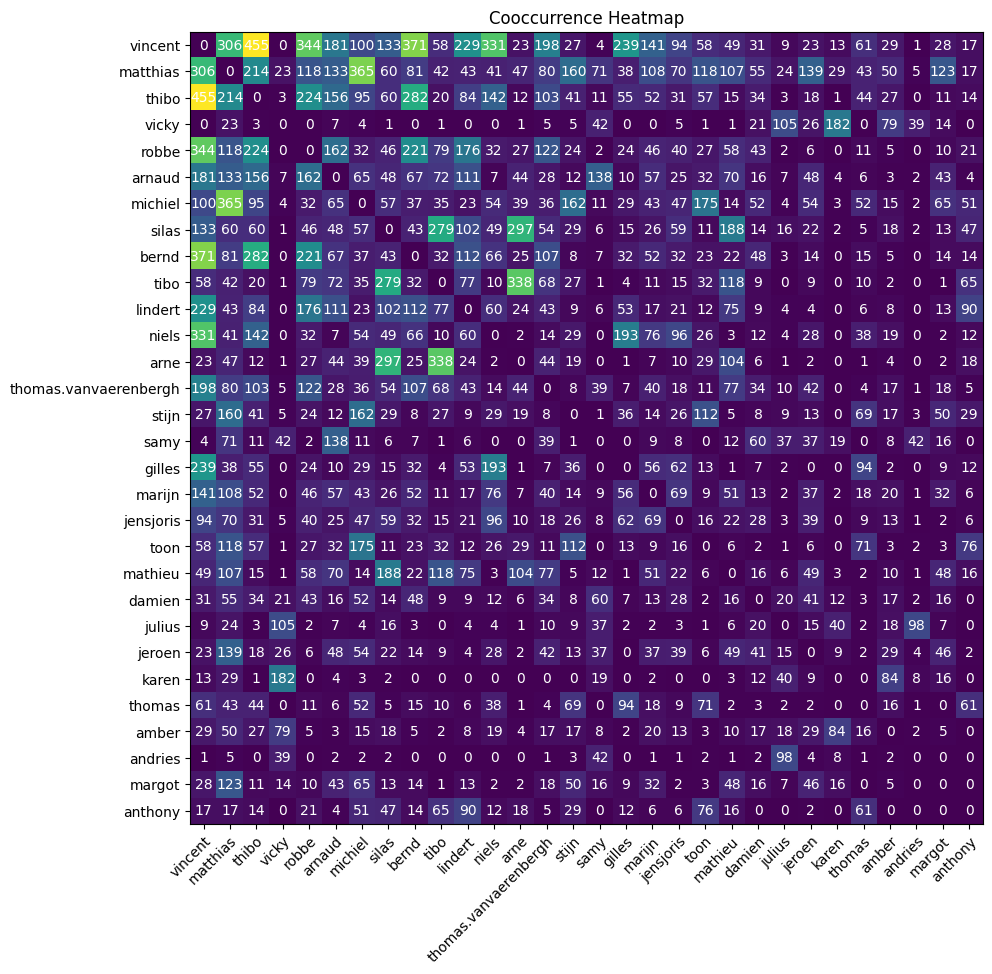

In [18]:
IC.plot_cooccurrence_heatmap(top_entities_30, figsize=10)


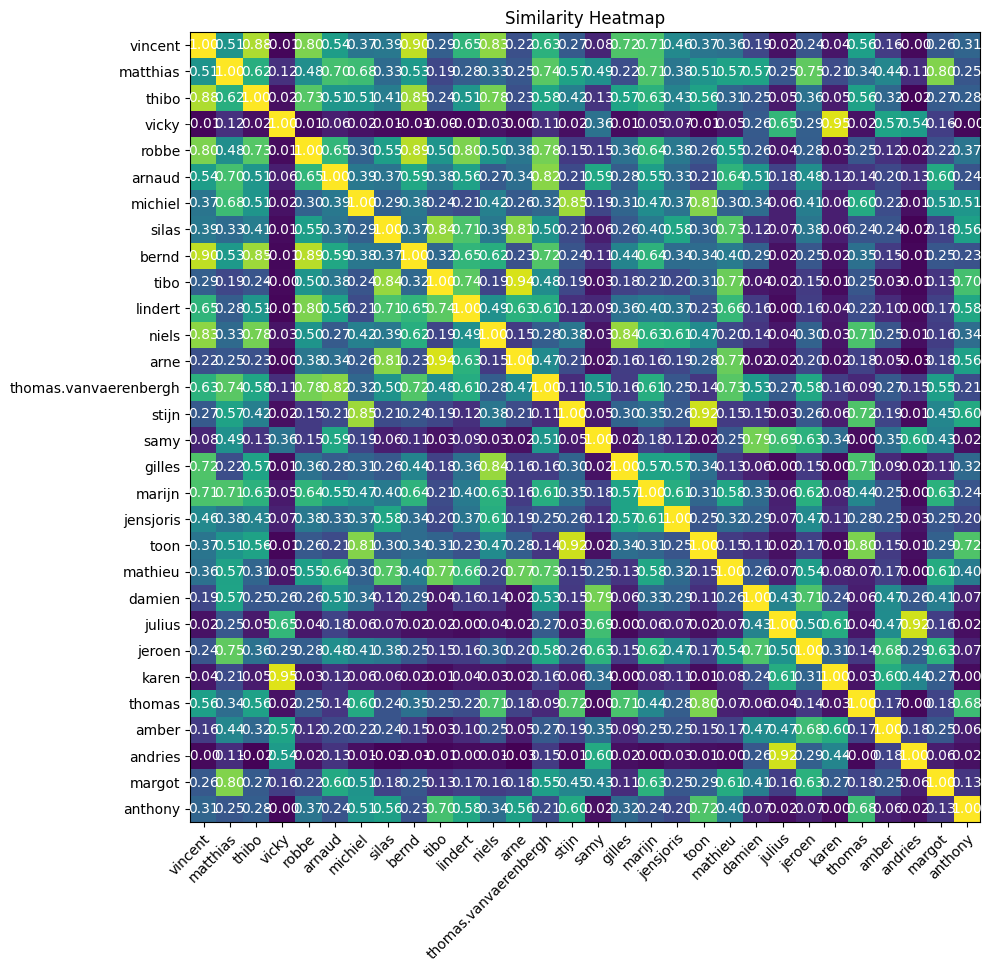

In [19]:
IC.plot_similarity_heatmap(top_entities_30, figsize=10)


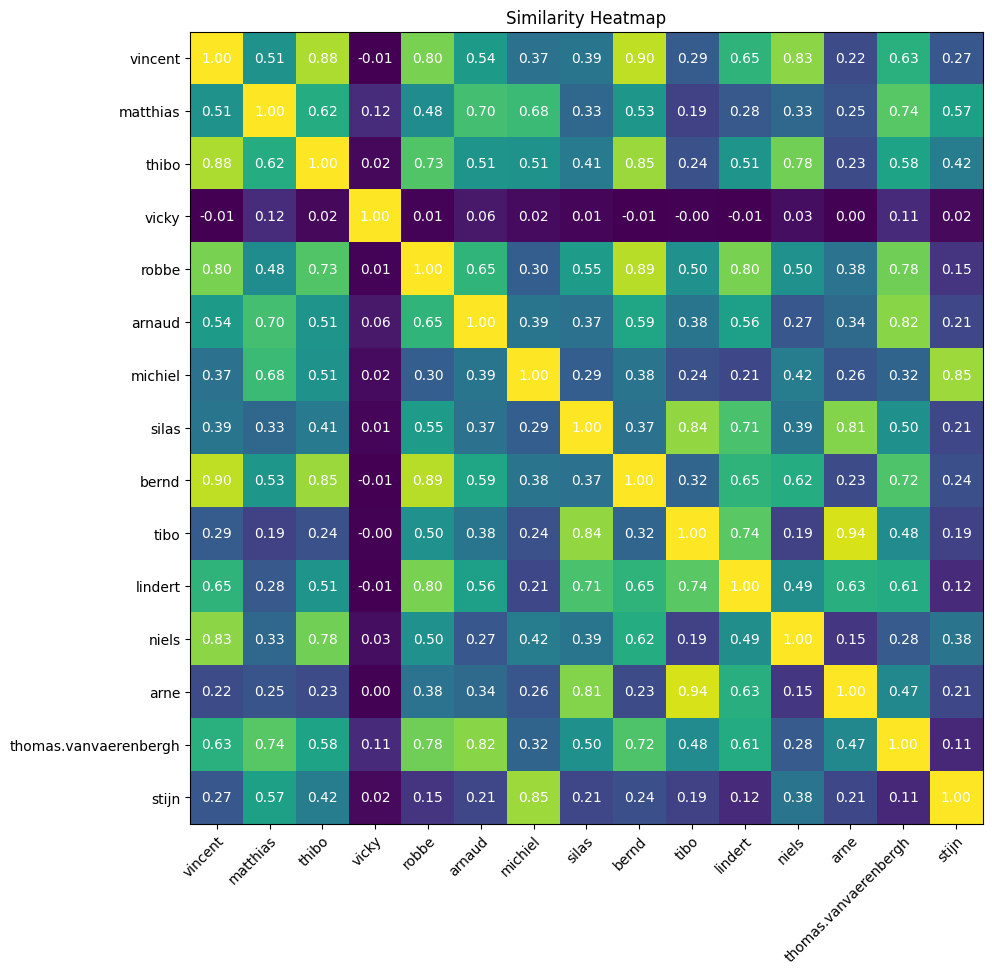

In [20]:
IC.plot_similarity_heatmap(top_entities_15, figsize=10)


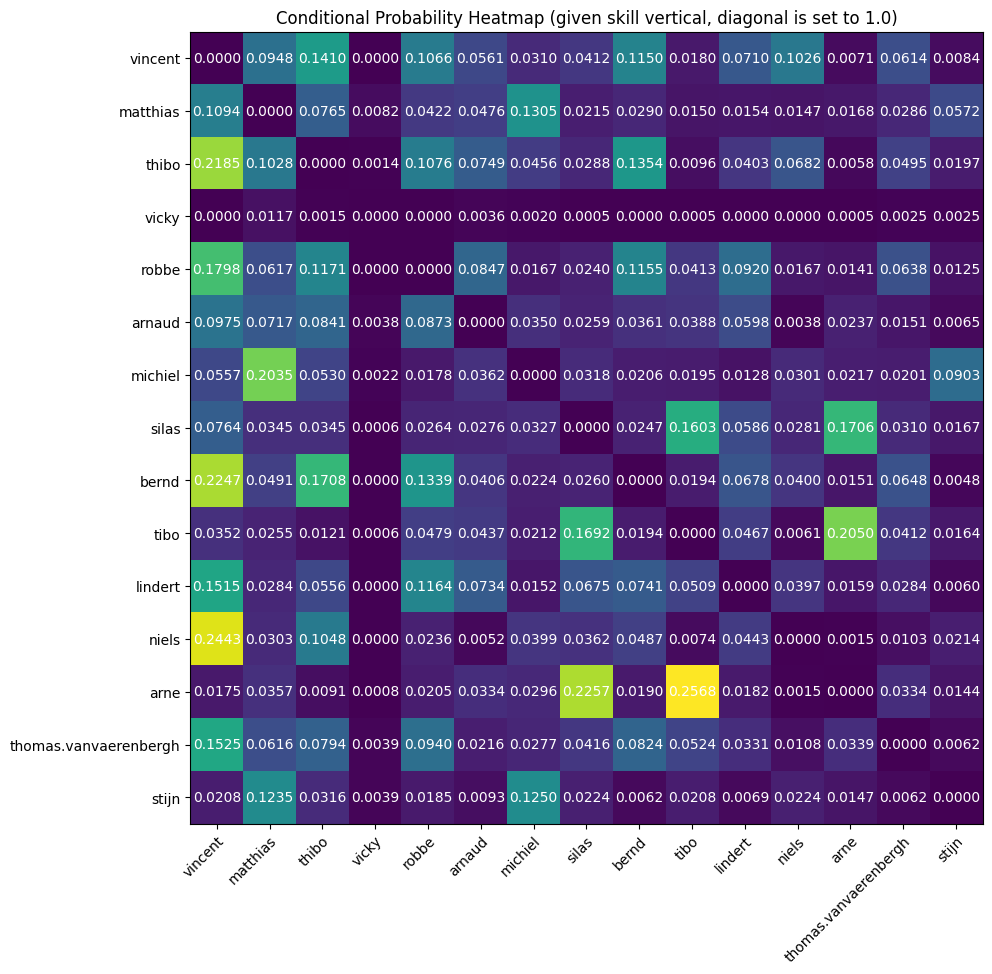

In [21]:
IC.plot_conditional_probability_heatmap(top_entities_15, figsize=10, fill_diagonal=False)


In [22]:
import numpy as np

def get_top_matches(reference_entity, candidate_entities, top_k=10):
    # Retrieve embeddings for the reference entity and candidate entities
    reference_embedding = IC.get_embeddings([reference_entity]).reshape(-1)
    candidate_embeddings = IC.get_embeddings(candidate_entities).reshape(-1, N_COMPONENTS)

    # Compute the cosine similarity between the reference and each candidate
    dot_products = np.dot(candidate_embeddings, reference_embedding)
    reference_norm = np.linalg.norm(reference_embedding)
    candidate_norms = np.linalg.norm(candidate_embeddings, axis=1)
    cosine_similarities = dot_products / (reference_norm * candidate_norms)

    # Get the top k indices with the highest cosine similarity scores
    top_k_indices = np.argsort(-cosine_similarities)[:top_k]

    # Return the top k candidate entities based on these indices
    top_matches = [candidate_entities[i] for i in top_k_indices]
    return top_matches

In [23]:
get_top_matches("marijn", occurring_readable_users)

['marijn',
 'matthias',
 'vincent',
 'robbe',
 'bernd',
 'thibo',
 'margot',
 'yasamin.karimi',
 'niels',
 'jeroen']

In [24]:
get_top_matches("niels", occurring_readable_users)

['niels',
 'jacob.demuynck',
 'gilles',
 'vincent',
 'bram.desimpelaere',
 'thibo',
 'mikkel.skovdal',
 'thomas',
 'simeon',
 'marijn']

In [25]:
get_top_matches("jeroen", occurring_readable_users)

['jeroen',
 'yasamin.karimi',
 'andreas_de_neve',
 'matthias',
 'ella.dekeyne',
 'damien',
 'julie',
 'amaury',
 'jonathan',
 'enrico']

In [26]:
get_top_matches("margot", occurring_readable_users)

['margot',
 'yasamin.karimi',
 'matthias',
 'marijn',
 'jeroen',
 'mathieu',
 'els.hugaerts',
 'arnaud',
 'thomas.vanvaerenbergh',
 'ella.dekeyne']

In [27]:
get_top_matches("vincent", occurring_readable_users)

['vincent',
 'bernd',
 'thibo',
 'niels',
 'robbe',
 'jacob.demuynck',
 'gilles',
 'marijn',
 'bram.desimpelaere',
 'lindert']

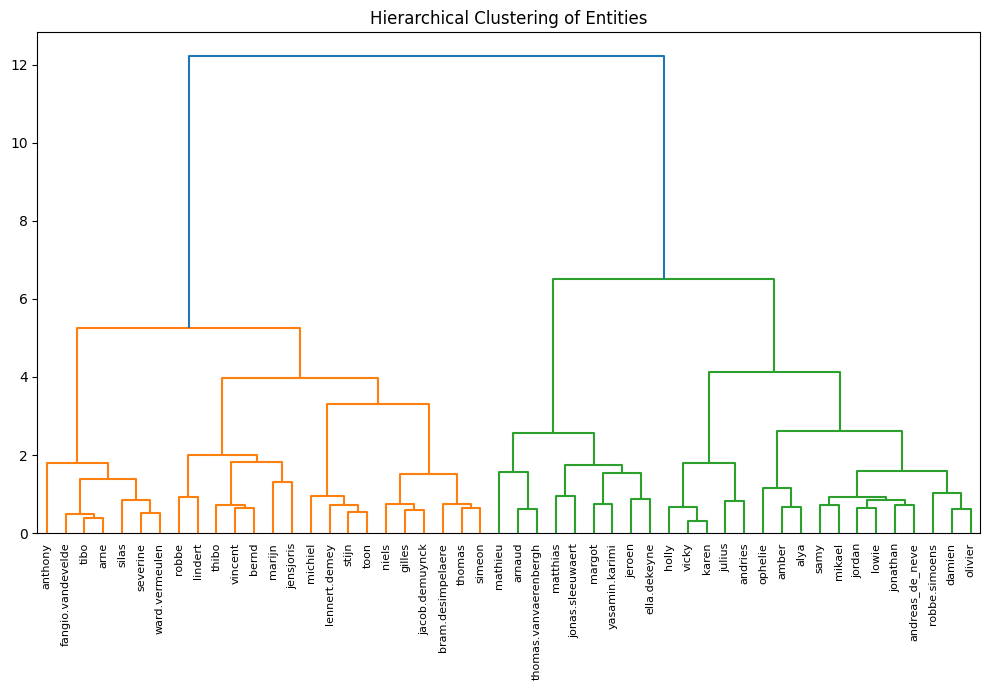

In [28]:
# Perform hierarchical clustering on the similarity matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

# Get similarity matrix
similarity_matrix = IC.get_similarity_matrix(top_entities)

# Convert similarity to distance (1 - similarity since higher similarity = closer)
distance_matrix = 1 - similarity_matrix

# Compute linkage matrix directly using scipy
Z = linkage(distance_matrix, method='ward')

# Create dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=top_entities, leaf_rotation=90)
plt.title('Hierarchical Clustering of Entities')
plt.tight_layout()
plt.show()

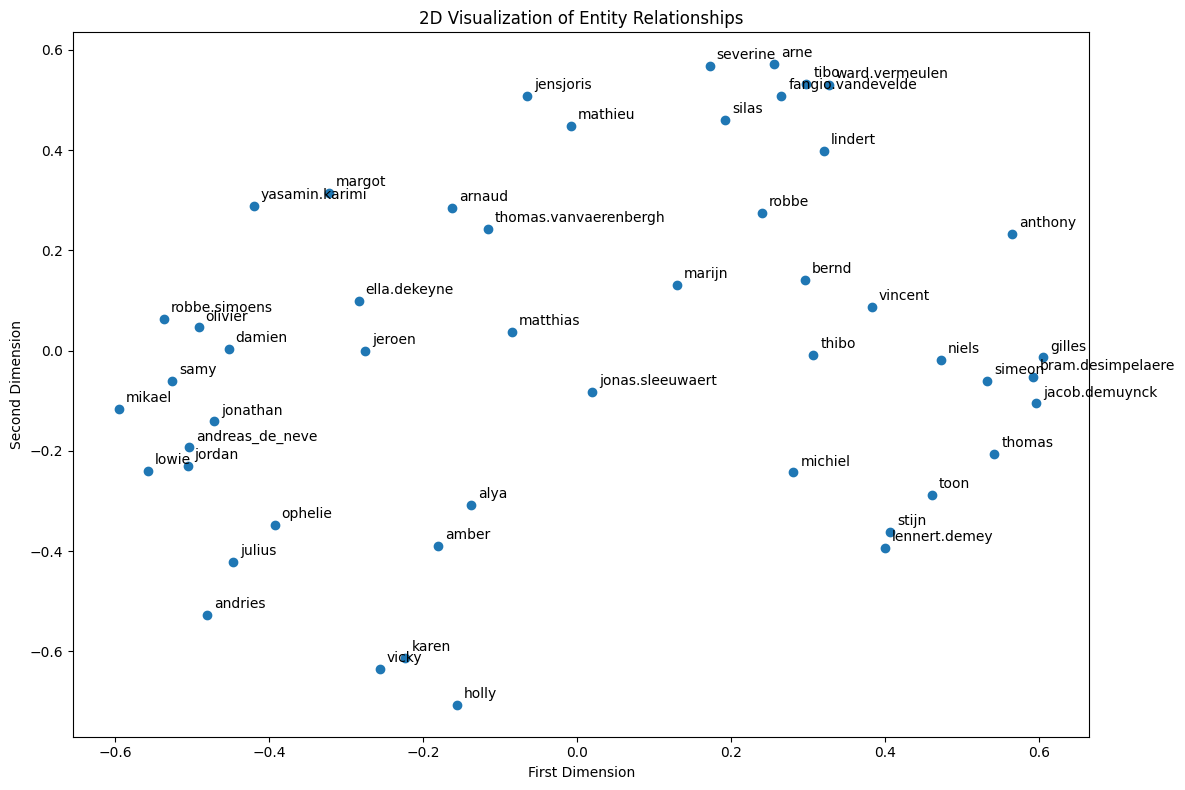

In [29]:
# Reduce dimensionality to 2D using MDS
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Create MDS model and fit to distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
coords_2d = mds.fit_transform(distance_matrix)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(coords_2d[:, 0], coords_2d[:, 1])

# Add labels for each point
for i, entity in enumerate(top_entities):
    plt.annotate(entity, (coords_2d[i, 0], coords_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

plt.title('2D Visualization of Entity Relationships')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.tight_layout()
plt.show()


In [44]:
shitpost_channel_interactions = {}

# Analyze thread interactions for each shitpost channel
for channel in shitpost_channels:
    shitpost_channel_interactions[channel] = get_thread_interactions(channel, users_dict, start_date='2023-04-30', end_date='2024-04-30')


# Extract all interactions across all shitpost channels into a single list
all_shitpost_interactions = []
for channel_interactions in shitpost_channel_interactions.values():
    for date_interactions in channel_interactions.values():
        all_shitpost_interactions.extend(date_interactions)


# Convert user IDs to readable names in all_shitpost_interactions
shitpost_readable_interactions = []
for interaction_group in all_shitpost_interactions:
    readable_names = [users_dict[uid]['name'] for uid in interaction_group]
    shitpost_readable_interactions.append(readable_names)

shitpost_readable_interactions



[['vicky', 'mikael', 'samy'],
 ['jeroen', 'matthias'],
 ['mikael'],
 ['julius'],
 ['paynter'],
 ['thomas.vanvaerenbergh', 'samy', 'arnaud'],
 ['jeroen', 'matthias'],
 ['marijn', 'julie', 'olivier'],
 ['amber', 'mikael'],
 ['marijn', 'jeroen', 'matthias'],
 ['karen', 'michiel', 'robbe.simoens'],
 ['samy'],
 ['dan', 'margot'],
 ['mathieu', 'arnaud'],
 ['jeroen'],
 ['julius'],
 ['vicky', 'julius', 'andreas_de_neve'],
 ['jensjoris'],
 ['matthias', 'lindert'],
 ['marijn', 'jeroen'],
 ['mikael', 'jonas.sleeuwaert', 'ella.dekeyne'],
 ['damien'],
 ['mikael', 'jonas.sleeuwaert', 'julius'],
 ['ella.dekeyne'],
 ['alya', 'thibo', 'damien'],
 ['jeroen', 'matthias', 'jensjoris'],
 ['julius'],
 ['matthias'],
 ['matthias', 'damien'],
 ['vicky', 'niels', 'arnaud'],
 ['matthias', 'olivier', 'robbe.simoens'],
 ['vicky'],
 ['vicky'],
 ['vicky'],
 ['vicky'],
 ['thomas.vanvaerenbergh', 'samy', 'arnaud'],
 ['jeroen'],
 ['vicky'],
 ['michiel', 'dan', 'matthias'],
 ['julie', 'matthias', 'margot'],
 ['vicky'],


In [45]:
from coherence import InventoryCoherence

N_COMPONENTS = 30
IC_shitpost = InventoryCoherence(shitpost_readable_interactions, n_components=N_COMPONENTS, shift_term=1)


In [47]:
occurring_readable_users_shitpost = [user for user in readable_users if user in IC_shitpost.entity_count_dict]

In [50]:
X_items = 50

#get the top X entities
top_entities_dict = {entity: count for entity, count in sorted(IC_shitpost.entity_count_dict.items(), key=lambda item: item[1], reverse=True)[:X_items]}
print("top entities= ", top_entities_dict)

top_entities_shitpost = list(top_entities_dict.keys())


top entities=  {'vincent': 332, 'thibo': 303, 'amber': 256, 'thomas.vanvaerenbergh': 255, 'thomas': 229, 'matthias': 205, 'silas': 203, 'niels': 195, 'damien': 164, 'julius': 150, 'stijn': 149, 'jonathan': 127, 'alya': 125, 'gilles': 124, 'robbe.simoens': 120, 'marijn': 119, 'bernd': 118, 'andries': 112, 'ophelie': 110, 'arnaud': 103, 'olivier': 82, 'jensjoris': 80, 'robbe': 78, 'lennert.demey': 77, 'arne': 69, 'lowie': 62, 'samy': 61, 'jacob.demuynck': 61, 'severine': 52, 'jeroen': 51, 'lindert': 51, 'ella.dekeyne': 50, 'amaury': 48, 'mathieu': 47, 'michiel': 46, 'jonas.sleeuwaert': 40, 'niels.thiel': 38, 'enrico': 38, 'lennert566': 37, 'simeon': 36, 'anthony': 35, 'eniko': 35, 'mikkel.skovdal': 32, 'tibo': 29, 'mikael': 28, 'paynter': 28, 'bram.desimpelaere': 28, 'vicky': 24, 'jordan': 23, 'toon': 22}


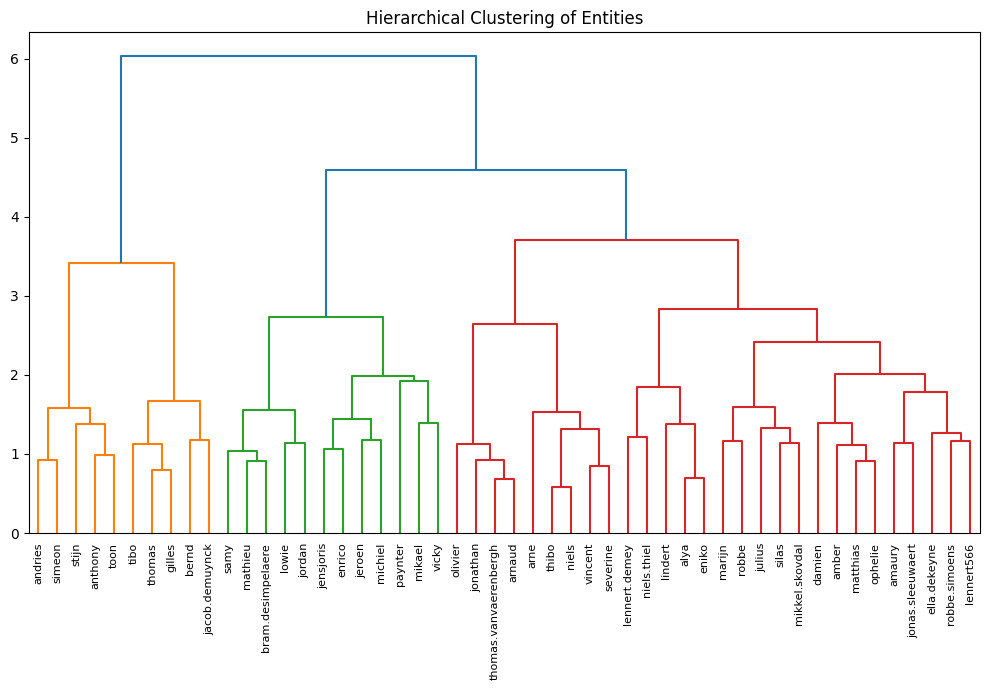

In [52]:
# Perform hierarchical clustering on the similarity matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

# Get similarity matrix
similarity_matrix = IC_shitpost.get_similarity_matrix(top_entities_shitpost)

# Convert similarity to distance (1 - similarity since higher similarity = closer)
distance_matrix = 1 - similarity_matrix

# Compute linkage matrix directly using scipy
Z = linkage(distance_matrix, method='ward')

# Create dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=top_entities_shitpost, leaf_rotation=90)
plt.title('Hierarchical Clustering of Entities')
plt.tight_layout()
plt.show()

In [53]:
IC.similarity("marijn", "vincent")

0.710570185723292

In [54]:
IC_shitpost.similarity("marijn", "vincent")

0.45214452841622454

In [55]:
IC_shitpost.similarity("marijn", "robbe")

0.5561678800463965

In [56]:
IC.similarity("marijn", "robbe")

0.6444082075967189

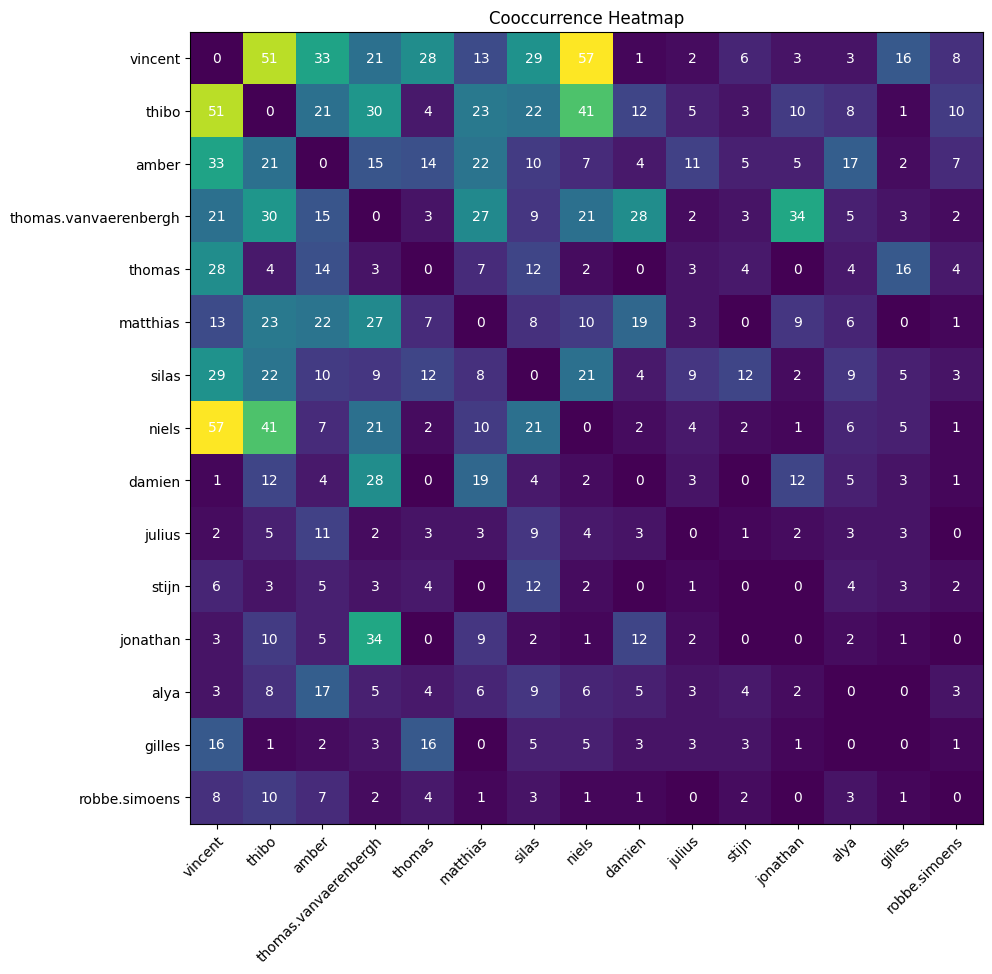

In [61]:
IC_shitpost.plot_cooccurrence_heatmap(top_entities_shitpost[:15], figsize=10)

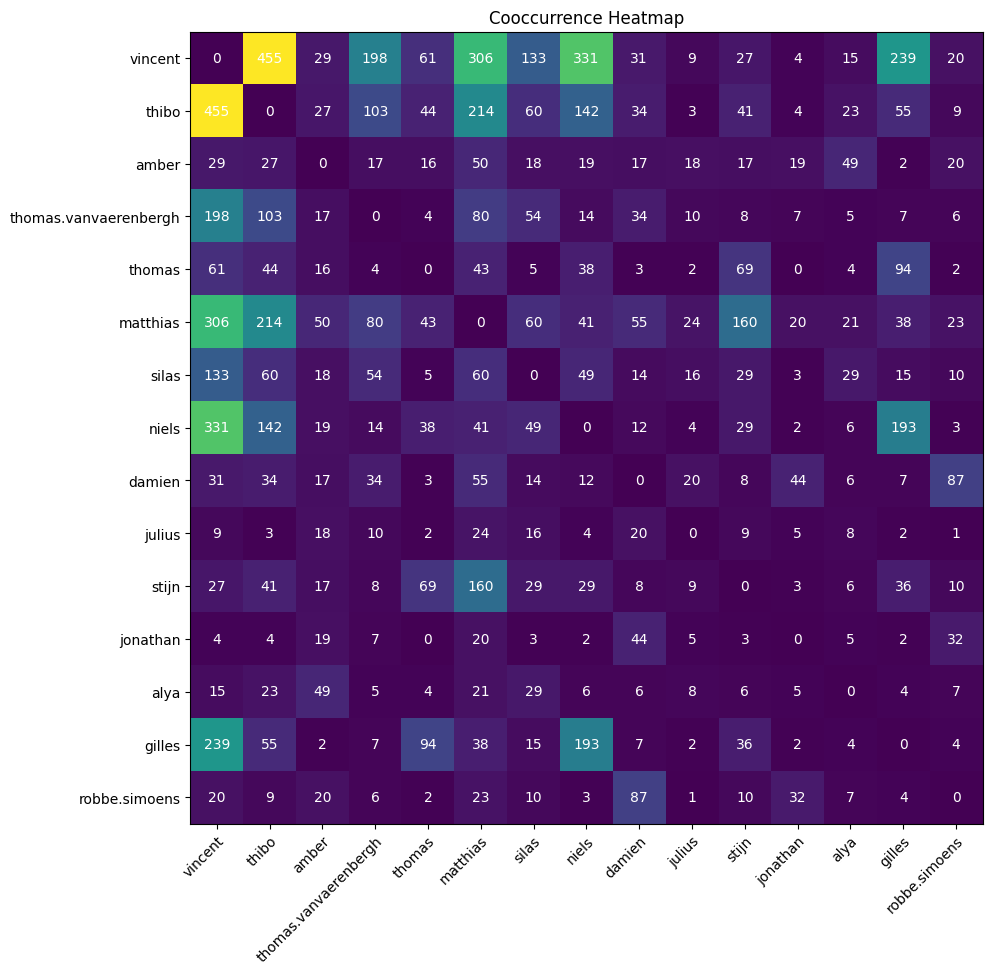

In [62]:
IC.plot_cooccurrence_heatmap(top_entities_shitpost[:15], figsize=10)

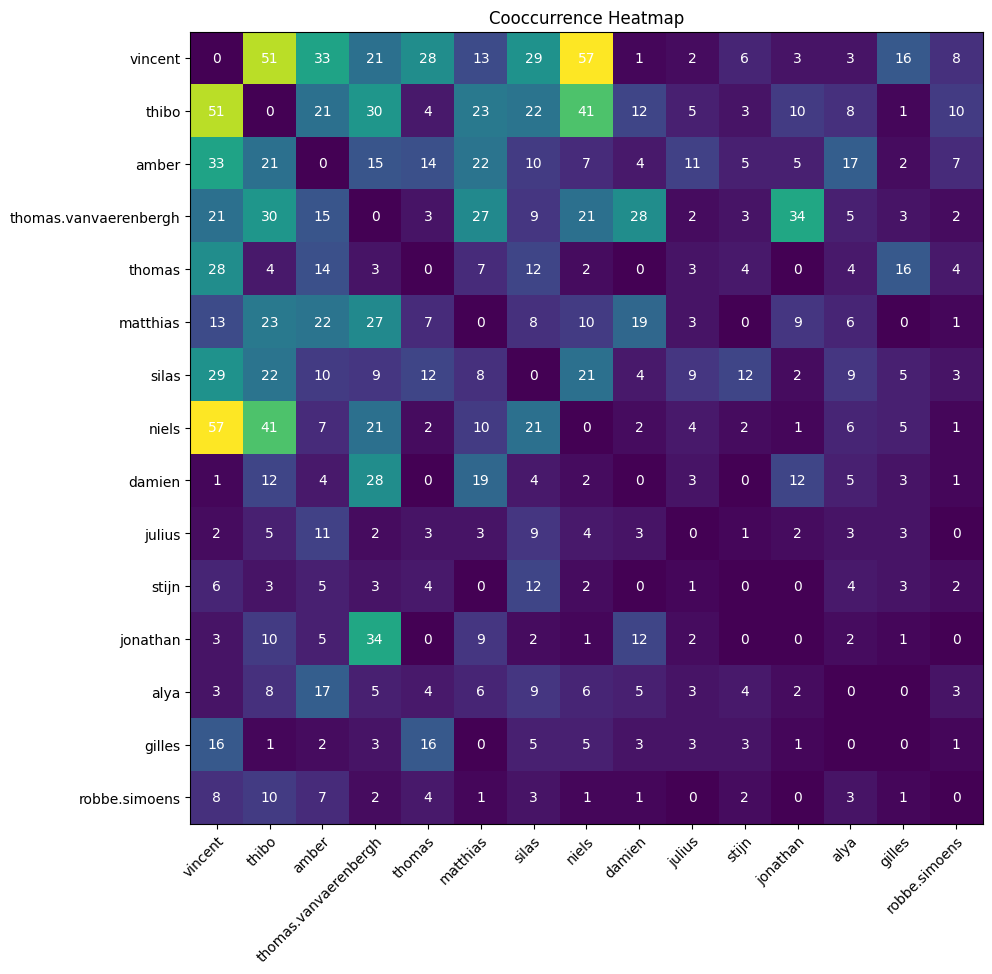

In [79]:
IC_shitpost.plot_cooccurrence_heatmap(top_entities_shitpost[:15], figsize=10)

In [74]:
def are_you_more_friends_or_colleagues(user1, user2):
    #get the work similarity between the two users
    work_similarity = IC.similarity(user1, user2)
    #get the shitpost similarity between the two users
    shitpost_similarity = IC_shitpost.similarity(user1, user2)

    #calculate the average similarity someone has with the other users
    all_work_similarities = IC.get_similarity_matrix(occurring_readable_users)
    #get the row of the user1
    user1_row = all_work_similarities[user1]
    #get the row of the user2
    user2_row = all_work_similarities[user2]
    #get the average similarity between the two users
    average_work_similarity_user1 = np.mean(user1_row)
    average_work_similarity_user2 = np.mean(user2_row)


    print({
        "user1": user1,
        "user2": user2,
        "work_similarity": work_similarity,
        "shitpost_similarity": shitpost_similarity,
        "average_work_similarity_user1": average_work_similarity_user1,
        "average_work_similarity_user2": average_work_similarity_user2
    })

    # #user 1 needs to be more similar to the average work and user 2 needs to be more similar to the average work
    # if work_similarity > average_work_similarity_user1 and work_similarity > average_work_similarity_user2:
    #     return "You are more friends with " + user2
    
    # #user 2 needs to be more similar to the average work and user 1 needs to be more similar to the average work
    # if work_similarity > average_work_similarity_user1 and work_similarity > average_work_similarity_user2:
    #     return "You are more friends with " + user2
    # else:
    #     return "You are more colleagues with " + user2


    # if work_similarity > shitpost_similarity:
    #     return "You are more friends with " + user2
    # else:
    #     return "You are more colleagues with " + user2


In [75]:
are_you_more_friends_or_colleagues("marijn", "vincent")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [72]:
are_you_more_friends_or_colleagues("marijn", "robbe")

'You are more friends with robbe'

In [73]:
are_you_more_friends_or_colleagues("marijn", "stijn")

'You are more friends with stijn'